# Testes com [Dask](https://dask.org/) em Python

Python é uma linguagem que une diferentes ferramentas para a ciência de dados, Dask é uma biblioteca em python para auxiliar a análise de grandes volumes de dados.

A programação paralela significa dividir o problema em partes separadas e unir as partes no final do processamento, Dask possui a escalabilidade existente no ecossistema python.

Os dados são divididos em chunks que podem ser manipulados indenpendentemente em paralelo.

In [3]:
from dask.distributed import Client
client = Client(n_workers = 4)

In [4]:
def fibonacci(n):
    if n < 3:
        return 1
    else:
        return fibonacci(n - 2) + fibonacci(n - 1)

In [14]:
from dask import delayed
from time import sleep

In [60]:
%%time
# Serial

x = fibonacci(10)
y = fibonacci(20)
z = fibonacci(30)
soma = sum([x, y, z])

CPU times: user 135 ms, sys: 14.5 ms, total: 150 ms
Wall time: 144 ms


In [62]:
%%time
print(soma)

838860
CPU times: user 77 µs, sys: 0 ns, total: 77 µs
Wall time: 52.2 µs


In [64]:
%%time
# Paralelo, construção de um gráfico

x = delayed(fibonacci)(10)
y = delayed(fibonacci)(20)
z = delayed(fibonacci)(30)
soma = delayed(sum)([x,y,z])

CPU times: user 1.48 ms, sys: 214 µs, total: 1.7 ms
Wall time: 1.08 ms


In [65]:
%%time
# União dos dados partidos
soma.compute()

CPU times: user 23.9 ms, sys: 4.77 ms, total: 28.7 ms
Wall time: 158 ms


838860

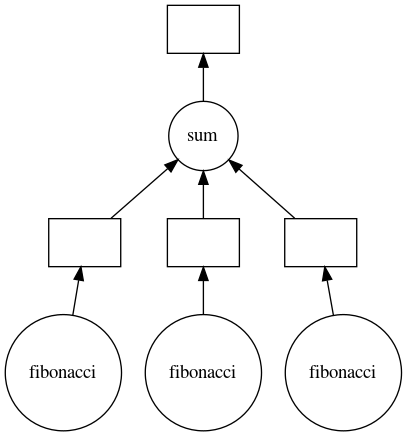

In [66]:
soma.visualize()

In [ ]:
client.close()